We start with MAF , defining the stellar density regions. Based on the MAF map, we 
obtained from NOAO archive the image corresponding to a given stellar density regime (with similar depth and filter as LSST r  ) : 

20% :  c4d_170122_055542_ooi_g_v1.fits.fz

15% : 

10% : 

5% :  c4d_160316_065235_ooi_g_v1.fits.fz

### Downloading NOAO images to NCSA 

Example for 20% field - the same for other field densities.

1) We went to http://archive.noao.edu/search/query  , selected : 
* ra,dec = 120.844   , -24.031667
* search box  =  10 arcmin 
* 90 < exposure < 125 
* telescope: CTIO 4m + DECam imager 
* Calibrated images only 
* public release date < today 

<img src="figures/1_query_noao.png">

2) We obtained  wtmap, dqmask, and  image, selected for staging
<img src="figures/2_query_results.png">

3) We ssh to NCSA : 

     ssh scichris@lsst-dev.ncsa.illinois.edu 
     
4) We download staged data from NOAO public server (user number is assigned at each search) : 

    lftp -u anonymous,lftp archive.noao.edu
    cd user_506119 
    mirror -L .   
5) We move the images to noao_data/  directory  with subdirectories  instcal/  wtmap/  dqmask/:
    
    mv c4d_170122_055542_ooi_g_v1.fits.fz noao_files/instcal/
    mv c4d_170122_055542_oow_g_v1.fits.fz noao_files/wtmap/
    mv c4d_170122_055542_ood_g_v1.fits.fz noao_files/dqmask/
    

### Processing the DECam images in NCSA with LSST Stack 

The following is an example for 20% field : those would be similar for other fields, with differing visit number .

1) We login to NCSA:  
    
    ssh scichris@lsst-dev.ncsa.illinois.edu
    
2) We setup the tools : 
        
    source /ssd/lsstsw/stack/loadLSST.bash
    setup obs_decam

3) We ingest the image ( assumed to reside in the noao_files/ subdirectories ) to repo/ directory : 
    
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_170122_055542*.fits.fz
   
At this stage we note what visit number is assigned to this image (it is also saved in the FITS header) , eg 
   
   ingest INFO: /home/scichris/noao_files/instcal/c4d_170122_055542_ooi_g_v1.fits.fz --<link>--> /home/scichris/repo/**0611980**/instcal0611980.fits.fz
   
   
4) Process the image  ( here we process all CCD's - otherwise we would specify ccdnum = #,  eg. 10 )  

    processCcd.py repo --rerun proc20perc  --id visit=611980  -C config_processccd.py --clobber-config


Move the results of LSST processing from the NCSA machine to a local workstation (eg. my laptop) : 

    cd /Users/chris/GradResearch/LSST_crowded_fields/data_products/LSST_Stack/DECam/
    mkdir 611980
    mv 611980
    scp scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/repo/rerun/proc20perc/611980/src/\*.fits .
     scp scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/repo/rerun/proc20perc/611980/calexp/\*.fits .

In [382]:
# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import urllib.request

from astropy.coordinates import SkyCoord
from astropy import units as u

from itertools import product
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from scipy.stats import binned_statistic as bs


### Download decaps single-epoch catalog  : 

In [212]:
# the cat name is based on the image name ... 
image_name = 'c4d_170122_055542_ooi_g'
cat_name = image_name + '_v1.cat.fits'
file_name  = '../data_products/DEcAPS_Catalogs/single_epoch/' + cat_name

In [22]:
# download the single-epoch catalog...

url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
urllib.request.urlretrieve(url, file_name)

('../data_products/DEcAPS_Catalogs/single_epoch/c4d_170122_055542_ooi_g_v1.cat.fits',
 <http.client.HTTPMessage at 0x10ee94828>)

### From decaps single-epoch catalog obtain tile numbers to download band-merged catalogs 

In [213]:
decaps_hdu = fits.open(file_name)
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
# hdu.info() would display all available tables - 
# there is a single catalog per CCD, 
# called 'S21_CAT', etc, based on CCD name. 

# save the zero point for this catalog 
decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  # one per entire image composed of multiple CCDs

In [223]:
decaps_hdu[163].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                    0                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'N25_HDR '           / Extension name                                 
IRAF-TLM= '2017-01-25T00:51:40' / Time of last modification                     
INHERIT =                    T / Inherits global header                         
DATE    = '2017-01-25T00:51:04' / Date FITS file was generated                  
WCSAXES =                    2 / WCS Dimensionality                             
DETSEC  = '[22533:24572,6149

Obtain the coordinates of the corners and the center of the mosaic : 

In [24]:
centra = decaps_hdu[0].header['CENTRA']
centdec  = decaps_hdu[0].header['CENTDEC']
corner_dic = {'ra':np.zeros(4), 
              'dec':np.zeros(4)}

for corner in np.arange(1,5) : 
    corn_ra = 'CORN'+str(corner)+'RA'
    corn_dec  = 'CORN'+str(corner)+'DEC'
    corner_dic['ra'][corner-1] = decaps_hdu[0].header[corn_ra]
    corner_dic['dec'][corner-1] = decaps_hdu[0].header[corn_dec]


In [25]:


# initialize corners and center of the field in degrees 
corners  = SkyCoord(ra = corner_dic['ra'] * u.degree, 
                   dec = corner_dic['dec']*u.degree)
center = SkyCoord(ra = centra * u.degree, dec = centdec * u.degree)

# print
print('This DECaPS field is centered on ')
print('l,b = %f, %f'%(center.galactic.l.degree, center.galactic.b.degree))

This DECaPS field is centered on 
l,b = 242.428426, 3.773817


In [26]:
# note: handle both positive and negative cases of galactic latitude, 
# since longitude is always positive

# Make an array of tile latitudes: 

# closest  half integer to the maximum latitude:
top_latitude = np.ceil(max(corners.galactic.b.degree)) 
bottom_latitude = np.floor(min(corners.galactic.b.degree))
latitudes = np.arange(bottom_latitude, top_latitude) + 0.5


# Make an array of tile longitudes 

maxL = max(corners.galactic.l.degree) 
minL = min(corners.galactic.l.degree)
if maxL - minL > 200 : 
    # the boundary case ( around 0 longitude)
    left_longitude = np.floor(maxL)
    right_longitude = np.ceil(minL)
    a = np.arange(left_longitude, 360 ) +0.5
    longitudes = np.append(a, np.arange(1,right_longitude)-0.5) 
else : 
    # the standard case (both on same side )
    left_longitude = np.floor(minL)
    right_longitude = np.ceil(maxL)
    longitudes = np.arange(left_longitude, right_longitude) + 0.5
    

# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/decam_flux_l1.5bm6.5.fits 
decaps_catalogs = []
for lat,lon in product(latitudes, longitudes):
    if lat >= 0 : 
        catname = 'decam_flux_l' + str(lon) + 'b'  + str(lat) + '.fits'
    if lat < 0 : 
        catname  = 'decam_flux_l' + str(lon) + 'b'  + 'm' + str(lat)[1:]+ '.fits'
    decaps_catalogs.append(catname)
    
    
print('We will try to download')
print(decaps_catalogs)    

We will download
['decam_flux_l241.5b2.5.fits', 'decam_flux_l242.5b2.5.fits', 'decam_flux_l243.5b2.5.fits', 'decam_flux_l241.5b3.5.fits', 'decam_flux_l242.5b3.5.fits', 'decam_flux_l243.5b3.5.fits', 'decam_flux_l241.5b4.5.fits', 'decam_flux_l242.5b4.5.fits', 'decam_flux_l243.5b4.5.fits', 'decam_flux_l241.5b5.5.fits', 'decam_flux_l242.5b5.5.fits', 'decam_flux_l243.5b5.5.fits']


In [46]:
print('First check which tiles are available : ')
# Check that against the list of what is available ... 
# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/
url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'
with urllib.request.urlopen(url) as response:
    html = response.read()


In [63]:
# we convert bytes object to a string 
html_string = html.decode("utf-8") 

good_catalogs = []
for i in range(0,len(decaps_catalogs)) :
    if decaps_catalogs[i] in html_string:
        good_catalogs.append(decaps_catalogs[i])

In [64]:
print('We found that these are available : ')
print(good_catalogs)


['decam_flux_l241.5b2.5.fits',
 'decam_flux_l242.5b2.5.fits',
 'decam_flux_l243.5b2.5.fits',
 'decam_flux_l241.5b3.5.fits',
 'decam_flux_l242.5b3.5.fits',
 'decam_flux_l243.5b3.5.fits',
 'decam_flux_l241.5b4.5.fits',
 'decam_flux_l242.5b4.5.fits',
 'decam_flux_l243.5b4.5.fits',
 'decam_flux_l242.5b5.5.fits',
 'decam_flux_l243.5b5.5.fits']

In [72]:
print('But these have not been downloaded yet:')
downloaded = os.listdir('../data_products/DEcAPS_Catalogs/band_merged/')
mask_to_download = ~np.in1d(good_catalogs, downloaded)
get_catalogs = np.array(good_catalogs)[mask_to_download]
print(get_catalogs)

But these have not been downloaded yet:
['decam_flux_l242.5b5.5.fits' 'decam_flux_l243.5b5.5.fits']


In [73]:
# Note - this may take a while to run because it 
# will download all the needed catalog tiles ... 
import urllib.request
for file in get_catalogs : 
    file_name = '../data_products/DEcAPS_Catalogs/band_merged/'+file
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'+file
    urllib.request.urlretrieve(url, file_name)

Aside : illustrate the downloaded tiles : 

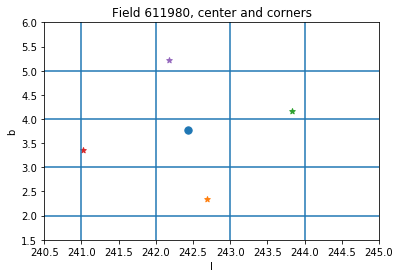

In [18]:
%matplotlib inline
        
# NOTE : The illustration only really works  for positive latitude, ( eg. b = 3,6 )
# and both longitudes must be on the same side of the 0 meridian ( eg. l = 241, 245)

# The decaps fields are arranged as a grid of 
# fields : 
l_field, b_field = center.galactic.l.degree, center.galactic.b.degree

lmin = np.floor(l_field) - 1 
bmin = np.floor(b_field) - 1
fig,ax = plt.subplots(1,1)
for l in np.arange(lmin,lmin+4) :
    ax.axvline(l)
for b in np.arange(bmin,bmin+4):
    ax.axhline(b)
ax.set_xlim(lmin-0.5,lmin+4)
ax.set_ylim(bmin-0.5, bmin+4)
ax.scatter(l_field, b_field, s=54)
for c in corners : 
    ax.scatter(c.galactic.l, c.galactic.b, s=34, marker='*')
ax.set_xlabel('l')
ax.set_ylabel('b')
ax.set_title('Field 611980, center and corners')

### Completeness : match the decals single-epoch catalog to LSST source catalog 

We match the decals catalog that corresponds exactly to the LSST-processed image, CCD by CCD. 
1) Read the LSST source catalogs for a given CCD 

In [75]:
visit = '611980'
outDir = '../data_products/LSST_Stack/DECam/'+visit+'/'

# read ccd by ccd,  and check corresponding ccd data in the 
# decals single-epoch catalog




'/Users/chris/GradResearch/LSST_crowded_fields/code'

In [324]:
visit = '611980'
outDir = '../data_products/LSST_Stack/DECam/'+visit+'/'


# first check calexp for zero point magnitude
# it is exactly the same for all CCDs in a mosaic 
calexp_files = os.listdir(outDir+'calexp/')
fname = calexp_files[0]
# read in the zeropoint from the calexp file 
calexp_hdu = fits.open(outDir+'calexp/' + fname)
lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
print('The lsst measured zeropoint for decam is %f'%lsst_zeropoint)

# Make only once : the translation of ccdnum to ccdname,  to position in the 
# decals hdu 

ccd_name_dict = {}
catalog_decaps_pos = {}

for i in range(1,180) : 
    if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
        ccdnum = decaps_hdu[i].header['CCDNUM']
        detpos = decaps_hdu[i].header['DETPOS']
        ccd_name_dict[ccdnum] = detpos
        catalog_decaps_pos[ccdnum] = int(i+2)
        
# The coveted dictionary of ccdnum  vs ccdname ! 
print(np.ravel(ccd_name_dict))

# and the translation of ccdnum  to hduposition of the catalog .... 
print(np.ravel(catalog_decaps_pos))


The lsst measured zeropoint for decam is 29.047000
[ {1: 'S29', 3: 'S31', 4: 'S25', 5: 'S26', 6: 'S27', 7: 'S28', 8: 'S20', 9: 'S21', 10: 'S22', 11: 'S23', 12: 'S24', 13: 'S14', 14: 'S15', 15: 'S16', 16: 'S17', 17: 'S18', 18: 'S19', 19: 'S8', 20: 'S9', 21: 'S10', 22: 'S11', 23: 'S12', 24: 'S13', 25: 'S1', 26: 'S2', 27: 'S3', 28: 'S4', 29: 'S5', 30: 'S6', 31: 'S7', 32: 'N1', 33: 'N2', 34: 'N3', 35: 'N4', 36: 'N5', 37: 'N6', 38: 'N7', 39: 'N8', 40: 'N9', 41: 'N10', 42: 'N11', 43: 'N12', 44: 'N13', 45: 'N14', 46: 'N15', 47: 'N16', 48: 'N17', 49: 'N18', 50: 'N19', 51: 'N20', 52: 'N21', 53: 'N22', 54: 'N23', 55: 'N24', 56: 'N25', 57: 'N26', 58: 'N27', 59: 'N28', 60: 'N29', 62: 'N31'}]
[ {1: 3, 3: 6, 4: 9, 5: 12, 6: 15, 7: 18, 8: 21, 9: 24, 10: 27, 11: 30, 12: 33, 13: 36, 14: 39, 15: 42, 16: 45, 17: 48, 18: 51, 19: 54, 20: 57, 21: 60, 22: 63, 23: 66, 24: 69, 25: 72, 26: 75, 27: 78, 28: 81, 29: 84, 30: 87, 31: 90, 32: 93, 33: 96, 34: 99, 35: 102, 36: 105, 37: 108, 38: 111, 39: 114, 40: 117, 4

src-0611980_23.fits
For ccd number 23 
The ccd name is S12
and the position in the decaps hdu catalog is 66


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:101: RuntimeWarning: invalid value encountered in true_divide


There are 5068 decaps sources  and 4461 lsst sources.
 3775 decaps srcs have an lsst match within 2 arcsec
 3640 decaps srcs have an lsst match within 0.50 mag
 3573 decaps srcs have an lsst match fulfilling both criteria


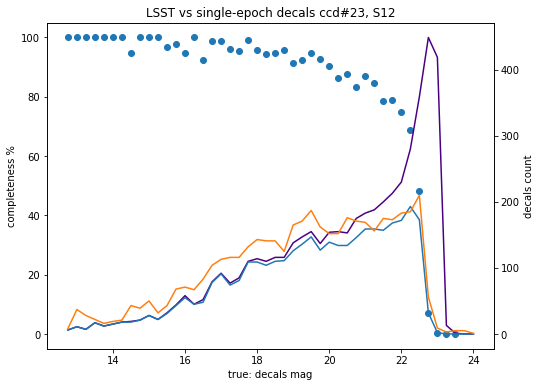

In [376]:
# processing individual ccd's ... 

#def process_src_ccd(outDir, visit, i):
i=0
src_files = os.listdir(outDir+'src/')
start = len('src-0'+visit+'_')
stop = len('.fits')
ccdnum  = src_files[i][start:-stop]  # string
ccd_number = float(ccdnum)
fname = 'src-0'+visit+'_'+ccdnum+'.fits'
hdu = fits.open(outDir +'src/'+ fname)
print(fname)

# convert to an AstroPy table 
ccd_data = Table(hdu[1].data)

# only consider positive fluxes... 
mask_neg_fluxes = ccd_data['base_PsfFlux_flux'].data > 0
# just select rows that don't have negative fluxes...
ccd_data_good = ccd_data[mask_neg_fluxes]
ccd_data_good['lsst_mag'] = -2.512 * np.log10(ccd_data_good['base_PsfFlux_flux'])   +\
   lsst_zeropoint

# Display mapping information
print('For ccd number %d ' % ccd_number)
print('The ccd name is %s'% ccd_name_dict[ccd_number])
print('and the position in the decaps hdu catalog is %d'%catalog_decaps_pos[ccd_number])

# read in decaps single-epoch catalog for that ccd... 
ccd_decaps_cat =  Table(decaps_hdu[catalog_decaps_pos[ccd_number]].data) 

# convert the fluxes to magnitudes 
ccd_decaps_cat['decaps_mag'] = -2.512 * np.log10(ccd_decaps_cat['flux'].data) +\
decaps_zeropoint





# Match sources from  decaps to lsst  per ccd 
# decam coordinates
decam_coord = SkyCoord(ra  = ccd_decaps_cat['ra']*u.degree, 
                       dec = ccd_decaps_cat['dec']*u.degree)  

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = ccd_data_good['coord_ra']*u.radian, 
                      dec= ccd_data_good['coord_dec']*u.radian)  


# indices are into lsst ccd catalog 
# match decaps into lsst ... 
idx, d2d, d3d = decam_coord.match_to_catalog_sky(lsst_coord)  

# stack the two catalogs 
lsst_decam= hstack([ccd_decaps_cat ,ccd_data_good[idx]],
               table_names=['decam','lsst']  )

print('There are %d decaps sources  and %d lsst sources.'%(len(decam_coord),
                                                      len(lsst_coord))
     )

# matches within two arcsec...
cut_arcsec = 2 
mask_arcsec = d2d.arcsec < cut_arcsec

# matches within 0.5 mag from one another ... 
lsst_decam['dmag'] = lsst_decam['lsst_mag'] - lsst_decam['decaps_mag']
cut_mag = 0.5
mask_mag = abs(lsst_decam['dmag'].data) < cut_mag
mask_comb  = mask_arcsec * mask_mag


print(' %d decaps srcs have an lsst match within %d arcsec'%(
    np.sum(mask_arcsec), cut_arcsec)
     )
print(' %d decaps srcs have an lsst match within %.2f mag'%(
    np.sum(mask_mag), cut_mag)
     )
print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
     )

# make  a smaller table with only 'good matches', 
# keeping only the magnitudes.. 
# matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag']]


# Using the original table, make a column to flag which 
# decaps srcs have a good lsst match 

# Initialize with zeros
lsst_decam['lsst_match'] = 0

# Set to 1 only where the match is good, i.e. fulfills the combined selection masks
lsst_decam['lsst_match'][mask_comb] = 1 

# Plot completeness ... 
bins = np.arange(12,24,0.25)

stat_mag = bs(lsst_decam['decaps_mag'], lsst_decam['decaps_mag'] , bins =bins ,
          statistic='count')

stat_count = bs(lsst_decam['decaps_mag'], lsst_decam['lsst_match'] , bins =bins ,
          statistic=np.sum)

decaps_count = stat_mag.statistic[1:]
lsst_matched_count = stat_count.statistic[1:]

completeness = 100 * (lsst_matched_count / decaps_count)

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.scatter(stat_mag.bin_edges[2:]+0.25, completeness)
ax.set_ylabel('completeness %')
ax.set_xlabel('true: decals mag')
ax.set_title('LSST vs single-epoch decals ccd#'+str(int(ccd_number))+\
             ', '+ ccd_name_dict[ccd_number])


ax2 = ax.twinx()

ax2.plot(stat_mag.bin_edges[2:]+0.25, decaps_count, c='indigo')
ax2.set_ylabel('decals count')

# single out only those decals that have a good lsst match,
# so that we can plot the counts of lsst along the magnitude 
# of matched decals source... 
matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag']]
stat_lsst = bs(  matched['decaps_mag'], matched['lsst_mag'] , bins = bins , 
             statistic = 'count' ) 

ax2.plot(stat_lsst.bin_edges[2:]+0.25, stat_lsst.statistic[1:])


# plot also raw lsst along lsst magnitudes ...
stat_raw = bs(ccd_data_good['lsst_mag'], ccd_data_good['lsst_mag'],
             bins=bins, statistic='count')
ax2.plot(stat_raw.bin_edges[2:]+0.25, stat_raw.statistic[1:])

fname = '../data_products/decaps_lsst_compare/' + 'ccd'+str(int(ccd_number))+\
             '_'+ ccd_name_dict[ccd_number] + '.png'
plt.show()
#plt.savefig(fname)
fig.clear()

In [372]:
# loop over all ccd's...
for i in range(len(calexp_files)) : 
    process_src_ccd(outDir, visit, i)

src-0611980_23.fits
For ccd number 23 
The ccd name is S12
and the position in the decaps hdu catalog is 66


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5068 decaps sources  and 4461 lsst sources.
 3775 decaps srcs have an lsst match within 2 arcsec
 3640 decaps srcs have an lsst match within 0.50 mag
 3573 decaps srcs have an lsst match fulfilling both criteria
src-0611980_35.fits
For ccd number 35 
The ccd name is N4
and the position in the decaps hdu catalog is 102


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5591 decaps sources  and 4974 lsst sources.
 3817 decaps srcs have an lsst match within 2 arcsec
 3971 decaps srcs have an lsst match within 0.50 mag
 3482 decaps srcs have an lsst match fulfilling both criteria
src-0611980_62.fits
For ccd number 62 
The ccd name is N31
and the position in the decaps hdu catalog is 180


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5637 decaps sources  and 4988 lsst sources.
 4230 decaps srcs have an lsst match within 2 arcsec
 4077 decaps srcs have an lsst match within 0.50 mag
 4001 decaps srcs have an lsst match fulfilling both criteria
src-0611980_19.fits
For ccd number 19 
The ccd name is S8
and the position in the decaps hdu catalog is 54


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5884 decaps sources  and 3139 lsst sources.
 2535 decaps srcs have an lsst match within 2 arcsec
 2556 decaps srcs have an lsst match within 0.50 mag
 2338 decaps srcs have an lsst match fulfilling both criteria
src-0611980_58.fits
For ccd number 58 
The ccd name is N27
and the position in the decaps hdu catalog is 171


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5497 decaps sources  and 4984 lsst sources.
 4238 decaps srcs have an lsst match within 2 arcsec
 4033 decaps srcs have an lsst match within 0.50 mag
 3981 decaps srcs have an lsst match fulfilling both criteria
src-0611980_39.fits
For ccd number 39 
The ccd name is N8
and the position in the decaps hdu catalog is 114


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


There are 6293 decaps sources  and 5057 lsst sources.
 4348 decaps srcs have an lsst match within 2 arcsec
 4173 decaps srcs have an lsst match within 0.50 mag
 4088 decaps srcs have an lsst match fulfilling both criteria
src-0611980_15.fits
For ccd number 15 
The ccd name is S16
and the position in the decaps hdu catalog is 42


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4813 decaps sources  and 4208 lsst sources.
 3202 decaps srcs have an lsst match within 2 arcsec
 3369 decaps srcs have an lsst match within 0.50 mag
 3036 decaps srcs have an lsst match fulfilling both criteria
src-0611980_42.fits
For ccd number 42 
The ccd name is N11
and the position in the decaps hdu catalog is 123


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


There are 5773 decaps sources  and 4820 lsst sources.
 4205 decaps srcs have an lsst match within 2 arcsec
 3925 decaps srcs have an lsst match within 0.50 mag
 3858 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


src-0611980_54.fits
For ccd number 54 
The ccd name is N23
and the position in the decaps hdu catalog is 159


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5637 decaps sources  and 5012 lsst sources.
 4126 decaps srcs have an lsst match within 2 arcsec
 3934 decaps srcs have an lsst match within 0.50 mag
 3831 decaps srcs have an lsst match fulfilling both criteria
src-0611980_03.fits
For ccd number 3 
The ccd name is S31
and the position in the decaps hdu catalog is 6
There are 4383 decaps sources  and 3967 lsst sources.
 3269 decaps srcs have an lsst match within 2 arcsec
 3208 decaps srcs have an lsst match within 0.50 mag
 3118 decaps srcs have an lsst match fulfilling both criteria
src-0611980_55.fits
For ccd number 55 
The ccd name is N24
and the position in the decaps hdu catalog is 162


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5333 decaps sources  and 4728 lsst sources.
 4029 decaps srcs have an lsst match within 2 arcsec
 3828 decaps srcs have an lsst match within 0.50 mag
 3751 decaps srcs have an lsst match fulfilling both criteria
src-0611980_43.fits
For ccd number 43 
The ccd name is N12
and the position in the decaps hdu catalog is 126


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5635 decaps sources  and 4798 lsst sources.
 4168 decaps srcs have an lsst match within 2 arcsec
 3937 decaps srcs have an lsst match within 0.50 mag
 3846 decaps srcs have an lsst match fulfilling both criteria
src-0611980_14.fits
For ccd number 14 
The ccd name is S15
and the position in the decaps hdu catalog is 39


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4879 decaps sources  and 4326 lsst sources.
 3454 decaps srcs have an lsst match within 2 arcsec
 3513 decaps srcs have an lsst match within 0.50 mag
 3291 decaps srcs have an lsst match fulfilling both criteria
src-0611980_38.fits
For ccd number 38 
The ccd name is N7
and the position in the decaps hdu catalog is 111


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4552 decaps sources  and 4350 lsst sources.
 3064 decaps srcs have an lsst match within 2 arcsec
 3321 decaps srcs have an lsst match within 0.50 mag
 2845 decaps srcs have an lsst match fulfilling both criteria
src-0611980_59.fits
For ccd number 59 
The ccd name is N28
and the position in the decaps hdu catalog is 174


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5470 decaps sources  and 4884 lsst sources.
 3795 decaps srcs have an lsst match within 2 arcsec
 3831 decaps srcs have an lsst match within 0.50 mag
 3476 decaps srcs have an lsst match fulfilling both criteria
src-0611980_18.fits
For ccd number 18 
The ccd name is S19
and the position in the decaps hdu catalog is 51
There are 4885 decaps sources  and 4251 lsst sources.
 3561 decaps srcs have an lsst match within 2 arcsec
 3473 decaps srcs have an lsst match within 0.50 mag
 3397 decaps srcs have an lsst match fulfilling both criteria
src-0611980_34.fits
For ccd number 34 
The ccd name is N3
and the position in the decaps hdu catalog is 99


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5711 decaps sources  and 4899 lsst sources.
 3842 decaps srcs have an lsst match within 2 arcsec
 3903 decaps srcs have an lsst match within 0.50 mag
 3567 decaps srcs have an lsst match fulfilling both criteria
src-0611980_22.fits
For ccd number 22 
The ccd name is S11
and the position in the decaps hdu catalog is 63


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5309 decaps sources  and 4562 lsst sources.
 3845 decaps srcs have an lsst match within 2 arcsec
 3704 decaps srcs have an lsst match within 0.50 mag
 3632 decaps srcs have an lsst match fulfilling both criteria
src-0611980_29.fits
For ccd number 29 
The ccd name is S5
and the position in the decaps hdu catalog is 84
There are 5107 decaps sources  and 4647 lsst sources.
 3923 decaps srcs have an lsst match within 2 arcsec
 3736 decaps srcs have an lsst match within 0.50 mag
 3669 decaps srcs have an lsst match fulfilling both criteria
src-0611980_13.fits
For ccd number 13 
The ccd name is S14
and the position in the decaps hdu catalog is 36


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5093 decaps sources  and 3832 lsst sources.
 3206 decaps srcs have an lsst match within 2 arcsec
 3058 decaps srcs have an lsst match within 0.50 mag
 3019 decaps srcs have an lsst match fulfilling both criteria
src-0611980_44.fits
For ccd number 44 
The ccd name is N13
and the position in the decaps hdu catalog is 129


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6629 decaps sources  and 3629 lsst sources.
 2606 decaps srcs have an lsst match within 2 arcsec
 2631 decaps srcs have an lsst match within 0.50 mag
 2221 decaps srcs have an lsst match fulfilling both criteria
src-0611980_52.fits
For ccd number 52 
The ccd name is N21
and the position in the decaps hdu catalog is 153


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5668 decaps sources  and 5031 lsst sources.
 4250 decaps srcs have an lsst match within 2 arcsec
 4077 decaps srcs have an lsst match within 0.50 mag
 4019 decaps srcs have an lsst match fulfilling both criteria
src-0611980_05.fits
For ccd number 5 
The ccd name is S26
and the position in the decaps hdu catalog is 12


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4861 decaps sources  and 4439 lsst sources.
 3586 decaps srcs have an lsst match within 2 arcsec
 3554 decaps srcs have an lsst match within 0.50 mag
 3422 decaps srcs have an lsst match fulfilling both criteria
src-0611980_25.fits
For ccd number 25 
The ccd name is S1
and the position in the decaps hdu catalog is 72


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6120 decaps sources  and 4398 lsst sources.
 3262 decaps srcs have an lsst match within 2 arcsec
 3384 decaps srcs have an lsst match within 0.50 mag
 2952 decaps srcs have an lsst match fulfilling both criteria
src-0611980_33.fits
For ccd number 33 
The ccd name is N2
and the position in the decaps hdu catalog is 96


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6083 decaps sources  and 5045 lsst sources.
 4387 decaps srcs have an lsst match within 2 arcsec
 4120 decaps srcs have an lsst match within 0.50 mag
 4047 decaps srcs have an lsst match fulfilling both criteria
src-0611980_48.fits
For ccd number 48 
The ccd name is N17
and the position in the decaps hdu catalog is 141


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5504 decaps sources  and 4824 lsst sources.
 4094 decaps srcs have an lsst match within 2 arcsec
 3879 decaps srcs have an lsst match within 0.50 mag
 3810 decaps srcs have an lsst match fulfilling both criteria
src-0611980_09.fits
For ccd number 9 
The ccd name is S21
and the position in the decaps hdu catalog is 24
There are 4855 decaps sources  and 4480 lsst sources.
 3752 decaps srcs have an lsst match within 2 arcsec
 3630 decaps srcs have an lsst match within 0.50 mag
 3556 decaps srcs have an lsst match fulfilling both criteria
src-0611980_08.fits
For ccd number 8 
The ccd name is S20
and the position in the decaps hdu catalog is 21


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4595 decaps sources  and 4316 lsst sources.
 3579 decaps srcs have an lsst match within 2 arcsec
 3502 decaps srcs have an lsst match within 0.50 mag
 3439 decaps srcs have an lsst match fulfilling both criteria
src-0611980_49.fits
For ccd number 49 
The ccd name is N18
and the position in the decaps hdu catalog is 144


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5611 decaps sources  and 4985 lsst sources.
 4258 decaps srcs have an lsst match within 2 arcsec
 4050 decaps srcs have an lsst match within 0.50 mag
 3988 decaps srcs have an lsst match fulfilling both criteria
src-0611980_32.fits
For ccd number 32 
The ccd name is N1
and the position in the decaps hdu catalog is 93


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6245 decaps sources  and 4805 lsst sources.
 3727 decaps srcs have an lsst match within 2 arcsec
 3868 decaps srcs have an lsst match within 0.50 mag
 3451 decaps srcs have an lsst match fulfilling both criteria
src-0611980_24.fits
For ccd number 24 
The ccd name is S13
and the position in the decaps hdu catalog is 69


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4778 decaps sources  and 4455 lsst sources.
 3684 decaps srcs have an lsst match within 2 arcsec
 3593 decaps srcs have an lsst match within 0.50 mag
 3516 decaps srcs have an lsst match fulfilling both criteria
src-0611980_04.fits
For ccd number 4 
The ccd name is S25
and the position in the decaps hdu catalog is 9


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4595 decaps sources  and 4284 lsst sources.
 3486 decaps srcs have an lsst match within 2 arcsec
 3372 decaps srcs have an lsst match within 0.50 mag
 3313 decaps srcs have an lsst match fulfilling both criteria
src-0611980_53.fits
For ccd number 53 
The ccd name is N22
and the position in the decaps hdu catalog is 156
There are 5780 decaps sources  and 5123 lsst sources.
 4099 decaps srcs have an lsst match within 2 arcsec
 3882 decaps srcs have an lsst match within 0.50 mag
 3798 decaps srcs have an lsst match fulfilling both criteria
src-0611980_45.fits
For ccd number 45 
The ccd name is N14
and the position in the decaps hdu catalog is 132


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6299 decaps sources  and 5168 lsst sources.
 4435 decaps srcs have an lsst match within 2 arcsec
 4249 decaps srcs have an lsst match within 0.50 mag
 4158 decaps srcs have an lsst match fulfilling both criteria
src-0611980_12.fits
For ccd number 12 
The ccd name is S24
and the position in the decaps hdu catalog is 33
There are 4386 decaps sources  and 4412 lsst sources.
 3518 decaps srcs have an lsst match within 2 arcsec
 3407 decaps srcs have an lsst match within 0.50 mag
 3349 decaps srcs have an lsst match fulfilling both criteria
src-0611980_28.fits
For ccd number 28 
The ccd name is S4
and the position in the decaps hdu catalog is 81


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5332 decaps sources  and 4855 lsst sources.
 3993 decaps srcs have an lsst match within 2 arcsec
 3806 decaps srcs have an lsst match within 0.50 mag
 3725 decaps srcs have an lsst match fulfilling both criteria
src-0611980_07.fits
For ccd number 7 
The ccd name is S28
and the position in the decaps hdu catalog is 18


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4589 decaps sources  and 4279 lsst sources.
 3529 decaps srcs have an lsst match within 2 arcsec
 3399 decaps srcs have an lsst match within 0.50 mag
 3341 decaps srcs have an lsst match fulfilling both criteria
src-0611980_50.fits
For ccd number 50 
The ccd name is N19
and the position in the decaps hdu catalog is 147


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5617 decaps sources  and 4378 lsst sources.
 3798 decaps srcs have an lsst match within 2 arcsec
 3615 decaps srcs have an lsst match within 0.50 mag
 3515 decaps srcs have an lsst match fulfilling both criteria
src-0611980_46.fits
For ccd number 46 
The ccd name is N15
and the position in the decaps hdu catalog is 135


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5801 decaps sources  and 5344 lsst sources.
 4281 decaps srcs have an lsst match within 2 arcsec
 4179 decaps srcs have an lsst match within 0.50 mag
 3972 decaps srcs have an lsst match fulfilling both criteria
src-0611980_11.fits
For ccd number 11 
The ccd name is S23
and the position in the decaps hdu catalog is 30


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4666 decaps sources  and 4243 lsst sources.
 3590 decaps srcs have an lsst match within 2 arcsec
 3431 decaps srcs have an lsst match within 0.50 mag
 3389 decaps srcs have an lsst match fulfilling both criteria
src-0611980_31.fits
For ccd number 31 
The ccd name is S7
and the position in the decaps hdu catalog is 90


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6932 decaps sources  and 2896 lsst sources.
 2122 decaps srcs have an lsst match within 2 arcsec
 2268 decaps srcs have an lsst match within 0.50 mag
 1911 decaps srcs have an lsst match fulfilling both criteria
src-0611980_27.fits
For ccd number 27 
The ccd name is S3
and the position in the decaps hdu catalog is 78


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5607 decaps sources  and 4719 lsst sources.
 3963 decaps srcs have an lsst match within 2 arcsec
 3815 decaps srcs have an lsst match within 0.50 mag
 3724 decaps srcs have an lsst match fulfilling both criteria
src-0611980_26.fits
For ccd number 26 
The ccd name is S2
and the position in the decaps hdu catalog is 75


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6110 decaps sources  and 4495 lsst sources.
 3863 decaps srcs have an lsst match within 2 arcsec
 3594 decaps srcs have an lsst match within 0.50 mag
 3559 decaps srcs have an lsst match fulfilling both criteria
src-0611980_30.fits
For ccd number 30 
The ccd name is S6
and the position in the decaps hdu catalog is 87


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


There are 4789 decaps sources  and 4473 lsst sources.
 3761 decaps srcs have an lsst match within 2 arcsec
 3620 decaps srcs have an lsst match within 0.50 mag
 3560 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


src-0611980_10.fits
For ccd number 10 
The ccd name is S22
and the position in the decaps hdu catalog is 27


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4731 decaps sources  and 4370 lsst sources.
 3654 decaps srcs have an lsst match within 2 arcsec
 3567 decaps srcs have an lsst match within 0.50 mag
 3506 decaps srcs have an lsst match fulfilling both criteria
src-0611980_47.fits
For ccd number 47 
The ccd name is N16
and the position in the decaps hdu catalog is 138
There are 5424 decaps sources  and 4866 lsst sources.
 3987 decaps srcs have an lsst match within 2 arcsec
 3816 decaps srcs have an lsst match within 0.50 mag
 3752 decaps srcs have an lsst match fulfilling both criteria
src-0611980_51.fits
For ccd number 51 
The ccd name is N20
and the position in the decaps hdu catalog is 150


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 6124 decaps sources  and 5068 lsst sources.
 4361 decaps srcs have an lsst match within 2 arcsec
 4181 decaps srcs have an lsst match within 0.50 mag
 4104 decaps srcs have an lsst match fulfilling both criteria
src-0611980_06.fits
For ccd number 6 
The ccd name is S27
and the position in the decaps hdu catalog is 15


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4970 decaps sources  and 4339 lsst sources.
 3127 decaps srcs have an lsst match within 2 arcsec
 3392 decaps srcs have an lsst match within 0.50 mag
 2947 decaps srcs have an lsst match fulfilling both criteria
src-0611980_60.fits
For ccd number 60 
The ccd name is N29
and the position in the decaps hdu catalog is 177
There are 5525 decaps sources  and 4848 lsst sources.
 4147 decaps srcs have an lsst match within 2 arcsec
 3942 decaps srcs have an lsst match within 0.50 mag
 3874 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


src-0611980_37.fits
For ccd number 37 
The ccd name is N6
and the position in the decaps hdu catalog is 108


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4970 decaps sources  and 4651 lsst sources.
 3891 decaps srcs have an lsst match within 2 arcsec
 3747 decaps srcs have an lsst match within 0.50 mag
 3677 decaps srcs have an lsst match fulfilling both criteria
src-0611980_21.fits
For ccd number 21 
The ccd name is S10
and the position in the decaps hdu catalog is 60


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5220 decaps sources  and 4356 lsst sources.
 3613 decaps srcs have an lsst match within 2 arcsec
 3452 decaps srcs have an lsst match within 0.50 mag
 3386 decaps srcs have an lsst match fulfilling both criteria
src-0611980_01.fits
For ccd number 1 
The ccd name is S29
and the position in the decaps hdu catalog is 3
There are 4808 decaps sources  and 4353 lsst sources.
 3631 decaps srcs have an lsst match within 2 arcsec
 3514 decaps srcs have an lsst match within 0.50 mag
 3452 decaps srcs have an lsst match fulfilling both criteria
src-0611980_56.fits
For ccd number 56 
The ccd name is N25
and the position in the decaps hdu catalog is 165


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5869 decaps sources  and 5058 lsst sources.
 4270 decaps srcs have an lsst match within 2 arcsec
 4130 decaps srcs have an lsst match within 0.50 mag
 4046 decaps srcs have an lsst match fulfilling both criteria
src-0611980_40.fits
For ccd number 40 
The ccd name is N9
and the position in the decaps hdu catalog is 117


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5943 decaps sources  and 5188 lsst sources.
 4443 decaps srcs have an lsst match within 2 arcsec
 4211 decaps srcs have an lsst match within 0.50 mag
 4143 decaps srcs have an lsst match fulfilling both criteria
src-0611980_17.fits
For ccd number 17 
The ccd name is S18
and the position in the decaps hdu catalog is 48


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 4568 decaps sources  and 4283 lsst sources.
 3540 decaps srcs have an lsst match within 2 arcsec
 3410 decaps srcs have an lsst match within 0.50 mag
 3358 decaps srcs have an lsst match fulfilling both criteria
src-0611980_16.fits
For ccd number 16 
The ccd name is S17
and the position in the decaps hdu catalog is 45
There are 4787 decaps sources  and 4504 lsst sources.
 3691 decaps srcs have an lsst match within 2 arcsec
 3559 decaps srcs have an lsst match within 0.50 mag
 3492 decaps srcs have an lsst match fulfilling both criteria
src-0611980_41.fits
For ccd number 41 
The ccd name is N10
and the position in the decaps hdu catalog is 120


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5789 decaps sources  and 4853 lsst sources.
 4159 decaps srcs have an lsst match within 2 arcsec
 3926 decaps srcs have an lsst match within 0.50 mag
 3864 decaps srcs have an lsst match fulfilling both criteria
src-0611980_57.fits
For ccd number 57 
The ccd name is N26
and the position in the decaps hdu catalog is 168


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5511 decaps sources  and 5034 lsst sources.
 4196 decaps srcs have an lsst match within 2 arcsec
 4033 decaps srcs have an lsst match within 0.50 mag
 3955 decaps srcs have an lsst match fulfilling both criteria
src-0611980_20.fits
For ccd number 20 
The ccd name is S9
and the position in the decaps hdu catalog is 57


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5335 decaps sources  and 4613 lsst sources.
 3236 decaps srcs have an lsst match within 2 arcsec
 3486 decaps srcs have an lsst match within 0.50 mag
 2976 decaps srcs have an lsst match fulfilling both criteria
src-0611980_36.fits
For ccd number 36 
The ccd name is N5
and the position in the decaps hdu catalog is 105


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less


There are 5078 decaps sources  and 4751 lsst sources.
 4026 decaps srcs have an lsst match within 2 arcsec
 3839 decaps srcs have an lsst match within 0.50 mag
 3778 decaps srcs have an lsst match fulfilling both criteria


In [337]:
# Indeed,  ccd 44 , N13 looks weird ... 

5068

In [387]:
# Combine that so that we grab  all lsst sources from all ccd's , 
# and all decals sources from all ccd's, to improve statistics ... 

#def process_src_ccd(outDir, visit, i):


# Initialize storage AstroPy tables :
arr = {'lsst_mag':[], 'coord_ra':[],'coord_dec':[]}
ccd_lsst_stack = Table(arr, names=('lsst_mag', 'coord_ra', 'coord_dec'), 
                 dtype=('f8', 'f8', 'f8'))  

arr = {'decaps_mag':[],'ra':[],'dec':[]}
ccd_decaps_stack = Table(arr, names = ('decaps_mag', 'ra', 'dec'),
                        dtype = ('f8', 'f8', 'f8'))

# loop over all ccds adding to stacks...
#
src_files = os.listdir(outDir+'src/')
start = len('src-0'+visit+'_')
stop = len('.fits')

for i in range(len(src_files)):
    ccdnum  = src_files[i][start:-stop]  # string
    ccd_number = float(ccdnum)
    fname = 'src-0'+visit+'_'+ccdnum+'.fits'
    hdu = fits.open(outDir +'src/'+ fname)
    print(fname)
    
    # convert to an AstroPy table 
    ccd_data = Table(hdu[1].data)

    # only consider positive fluxes... 
    mask_neg_fluxes = ccd_data['base_PsfFlux_flux'].data > 0
    # just select rows that don't have negative fluxes...
    ccd_data_good = ccd_data[mask_neg_fluxes]
    ccd_data_good['lsst_mag'] = -2.512 * np.log10(ccd_data_good['base_PsfFlux_flux'])   +\
       lsst_zeropoint

    # keep only most relevant info... 
    ccd_lsst  =    ccd_data_good[['lsst_mag', 'coord_ra', 'coord_dec']] 

    # add to the stack
    ccd_lsst_stack    = vstack([ccd_lsst_stack ,ccd_lsst] )

    # Display mapping information
    print('  * ccd number %d ' % ccd_number)
    print('  * ccd name is %s'% ccd_name_dict[ccd_number])
    print('  * position in  decaps hdu  is %d'%catalog_decaps_pos[ccd_number])

    # read in decaps single-epoch catalog for that ccd... 
    ccd_decaps_cat =  Table(decaps_hdu[catalog_decaps_pos[ccd_number]].data) 

    # convert the fluxes to magnitudes 
    ccd_decaps_cat['decaps_mag'] = -2.512 * np.log10(ccd_decaps_cat['flux'].data) +\
    decaps_zeropoint

    # keep only the relevant info
    ccd_decaps = ccd_decaps_cat[['decaps_mag','ra','dec']]
    ccd_decaps_stack = vstack([ccd_decaps_stack, ccd_decaps])

print('Done')




src-0611980_23.fits
  * ccd number 23 
  * ccd name is S12
  * position in  decaps hdu  is 66
src-0611980_35.fits


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in log10


  * ccd number 35 
  * ccd name is N4
  * position in  decaps hdu  is 102
src-0611980_62.fits
  * ccd number 62 
  * ccd name is N31
  * position in  decaps hdu  is 180
src-0611980_19.fits
  * ccd number 19 
  * ccd name is S8
  * position in  decaps hdu  is 54
src-0611980_58.fits
  * ccd number 58 
  * ccd name is N27
  * position in  decaps hdu  is 171
src-0611980_39.fits
  * ccd number 39 
  * ccd name is N8
  * position in  decaps hdu  is 114
src-0611980_15.fits
  * ccd number 15 
  * ccd name is S16
  * position in  decaps hdu  is 42
src-0611980_42.fits
  * ccd number 42 
  * ccd name is N11
  * position in  decaps hdu  is 123
src-0611980_54.fits
  * ccd number 54 
  * ccd name is N23
  * position in  decaps hdu  is 159
src-0611980_03.fits
  * ccd number 3 
  * ccd name is S31
  * position in  decaps hdu  is 6
src-0611980_55.fits
  * ccd number 55 
  * ccd name is N24
  * position in  decaps hdu  is 162
src-0611980_43.fits
  * ccd number 43 
  * ccd name is N12
  * position in  de

In [391]:
print('Total decaps source number %d'%len(ccd_lsst_stack))
print('Total lsst source number %d'%len(ccd_decaps_stack))

Total decaps source number 275098
Total lsst source number 322654


There are 322654 decaps sources  and 275098 lsst sources.
 226227 decaps srcs have an lsst match within 2 arcsec
 220320 decaps srcs have an lsst match within 0.50 mag
 211844 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in less


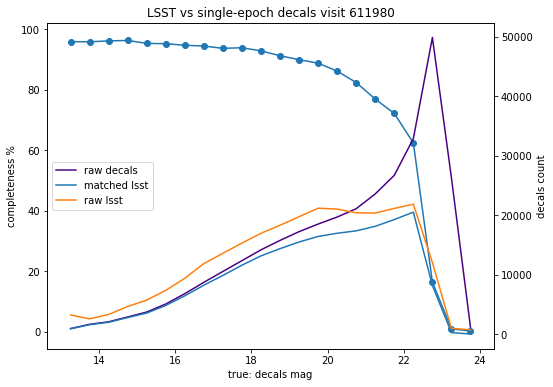

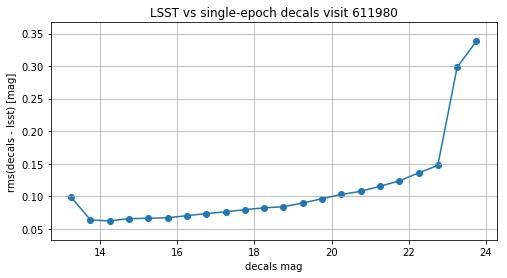

In [588]:


# Match sources from  decaps to lsst  per ccd 
# decam coordinates
decam_coord = SkyCoord(ra  = ccd_decaps_stack['ra']*u.degree, 
                       dec = ccd_decaps_stack['dec']*u.degree)  

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = ccd_lsst_stack['coord_ra']*u.radian, 
                      dec= ccd_lsst_stack['coord_dec']*u.radian)  


# indices are into lsst ccd catalog 
# match decaps into lsst ... 
idx, d2d, d3d = decam_coord.match_to_catalog_sky(lsst_coord)  

# stack the two catalogs 
lsst_decam= hstack([ccd_decaps_stack ,ccd_lsst_stack[idx]],
               table_names=['decam','lsst']  )

print('There are %d decaps sources  and %d lsst sources.'%(len(decam_coord),
                                                      len(lsst_coord))
     )

# matches within two arcsec...
cut_arcsec = 2 
mask_arcsec = d2d.arcsec < cut_arcsec

# matches within 0.5 mag from one another ... 
lsst_decam['dmag'] = lsst_decam['lsst_mag'] - lsst_decam['decaps_mag']
cut_mag = 0.5
mask_mag = abs(lsst_decam['dmag'].data) < cut_mag
mask_comb  = mask_arcsec * mask_mag


print(' %d decaps srcs have an lsst match within %d arcsec'%(
    np.sum(mask_arcsec), cut_arcsec)
     )
print(' %d decaps srcs have an lsst match within %.2f mag'%(
    np.sum(mask_mag), cut_mag)
     )
print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
     )

# make  a smaller table with only 'good matches', 
# keeping only the magnitudes.. 
# matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag']]


# Using the original table, make a column to flag which 
# decaps srcs have a good lsst match 

# Initialize with zeros
lsst_decam['lsst_match'] = 0

# Set to 1 only where the match is good, i.e. fulfills the combined selection masks
lsst_decam['lsst_match'][mask_comb] = 1 

# Plot completeness ... 
bins = np.arange(12,24,0.5)

stat_mag = bs(lsst_decam['decaps_mag'], lsst_decam['decaps_mag'] , bins =bins ,
          statistic='count')

stat_count = bs(lsst_decam['decaps_mag'], lsst_decam['lsst_match'] , bins =bins ,
          statistic=np.sum)



decaps_count = stat_mag.statistic[1:]
lsst_matched_count = stat_count.statistic[1:]

# Plot completeness : 
# how many decaps sources does lsst recover ?

# we classify a  match as good if :
# 1)  lsst counterpart is within 2 arcsec
# 2) lsst match has magnitude within 0.5 mag from the decaps magnitude 



completeness = 100 * (lsst_matched_count / decaps_count)

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(stat_mag.bin_edges[2:]+0.25, completeness)
ax.scatter(stat_mag.bin_edges[2:]+0.25, completeness)
ax.set_ylabel('completeness %')
ax.set_xlabel('true: decals mag')
ax.set_title('LSST vs single-epoch decals visit '+visit)


ax2 = ax.twinx()

ax2.plot(stat_mag.bin_edges[2:]+0.25, decaps_count, c='indigo', label='raw decals')
ax2.set_ylabel('decals count')

# single out only those decals that have a good lsst match,
# so that we can plot the counts of lsst along the magnitude 
# of matched decals source... 
matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag', 'dmag']]
stat_lsst = bs(  matched['decaps_mag'], matched['lsst_mag'] , bins = bins , 
             statistic = 'count' ) 

ax2.plot(stat_lsst.bin_edges[2:]+0.25, stat_lsst.statistic[1:], label='matched lsst')


# plot also raw lsst along lsst magnitudes ...
stat_raw = bs(ccd_lsst_stack['lsst_mag'], ccd_lsst_stack['lsst_mag'],
             bins=bins, statistic='count')
ax2.plot(stat_raw.bin_edges[2:]+0.25, stat_raw.statistic[1:], label='raw lsst')

plt.legend(loc = 'center left')

fname = '../data_products/decaps_lsst_compare/' + 'visit_'+visit+'.png'

plt.savefig(fname)
plt.show()
fig.clear()



# plot the photometric error vs magnitude ....
# calculate the rms only on sources that were matched... 
rms = lambda x : np.sqrt(np.mean(np.square(x)))
stat_rms_single = bs(matched['decaps_mag'],matched['dmag'], bins=bins,statistic=rms)
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(stat_rms_single.bin_edges[2:]+0.25, stat_rms_single.statistic[1:])
ax.plot(stat_rms_single.bin_edges[2:]+0.25, stat_rms_single.statistic[1:])
ax.set_ylabel('rms(decals - lsst) [mag]')
ax.set_xlabel('decals mag')
ax.grid()
ax.set_title('LSST vs single-epoch decals visit '+visit)
fname = '../data_products/decaps_lsst_compare/'+'visit_'+visit+'_rms.png'
plt.savefig(fname)

## Plot the photometric error vs magnitude 

In [414]:
# First use the stacked catalogs - taking all ccd sources from lsst,
# and then from decaps, and matching 

# Already done above, that was very simple. 
# Now use the multi-band tiled catalogs per density ...

good_catalogs

['decam_flux_l241.5b2.5.fits',
 'decam_flux_l242.5b2.5.fits',
 'decam_flux_l243.5b2.5.fits',
 'decam_flux_l241.5b3.5.fits',
 'decam_flux_l242.5b3.5.fits',
 'decam_flux_l243.5b3.5.fits',
 'decam_flux_l241.5b4.5.fits',
 'decam_flux_l242.5b4.5.fits',
 'decam_flux_l243.5b4.5.fits',
 'decam_flux_l242.5b5.5.fits',
 'decam_flux_l243.5b5.5.fits']

In [542]:
catDir = '../data_products/decaps_catalogs/band_merged/'

# we decided in the beginning which band-merged catalog tiles
# would be useful for this particular mosaic (image, visit)
# based on the image corners  
 
arr = {'g':[], 'ra':[],'dec':[],'flag_tile':[]}
decaps_stack = Table(arr,   dtype=('f8', 'f8', 'f8', 'i4'))

# now we read in catalog by catalog, 
# keeping only ra,dec, g magnitude only
# for those objects for which g-band flux > 0 

for i in range(len(good_catalogs)):
    #i=2
    cat_hdu = fits.open(catDir + good_catalogs[i])
    # cat_hdu.info()

    # convert the fits object to AstroPy table 
    cat_table = Table(cat_hdu[1].data)

    # select only ra, dec 
    cat_table_radec = cat_table[['ra','dec']]

    # http://docs.astropy.org/en/stable/io/fits/
    # tbdata.field(0)
    # get column names directly from hdulist 
    # cols = cat_hdu[1].columns

    # python arrays vs numpy arrays 
    # we win! https://astropy.readthedocs.io/en/v0.3/table/construct_table.html 
    tbdata = cat_hdu[1].data
    cat_hdu.close()
    mean_flux = Table(tbdata['mean'], names=('u', 'g', 'r', 'i','z','Y'))
    # we want to keep only g because the LSST photometry 
    # as done on an image in g-filter ... 
    mask_missing_g_flux = mean_flux['g'] > 0

    # convert to g magnitudes 
    gmag = -2.5 * np.log10(mean_flux['g'][mask_missing_g_flux])

    
    #flag_tile = Column
    ##print(len(cat_table_radec))
    #print(len(mean_flux))
    # select only the objects that have g-band detections
    decaps_select = cat_table_radec[mask_missing_g_flux]
    decaps_select.add_column(gmag)
    
    # add a column with a flag from which tile the data came...
    decaps_select['flag_tile'] = i 
    
    # add to stack :
    decaps_stack = vstack([decaps_stack, decaps_select])

    print('Added %d sources from %s' %(len(decaps_select), good_catalogs[i]))

Added 151181 sources from decam_flux_l241.5b2.5.fits
Added 171255 sources from decam_flux_l242.5b2.5.fits
Added 168266 sources from decam_flux_l243.5b2.5.fits
Added 121434 sources from decam_flux_l241.5b3.5.fits
Added 154393 sources from decam_flux_l242.5b3.5.fits
Added 159882 sources from decam_flux_l243.5b3.5.fits
Added 29716 sources from decam_flux_l241.5b4.5.fits
Added 122635 sources from decam_flux_l242.5b4.5.fits
Added 111851 sources from decam_flux_l243.5b4.5.fits
Added 7114 sources from decam_flux_l242.5b5.5.fits
Added 2098 sources from decam_flux_l243.5b5.5.fits


In [536]:
#decaps_select['flag_tile'] = 1

In [543]:
decaps_select

ra,dec,g,flag_tile
float64,float64,float32,int64
122.600168469,-23.9551400902,16.1225,10
122.600196934,-23.9905264521,18.0502,10
122.599819598,-23.963730062,18.4405,10
122.600149654,-24.0031328835,22.8063,10
122.600129487,-23.9971579263,22.4656,10
122.599599964,-23.9485782615,19.9711,10
122.599684182,-23.9685075472,21.8995,10
122.599052111,-23.9803749581,22.7861,10
122.520620454,-23.9710463668,23.6997,10


In [544]:
# So in total we have the decaps band-merged catalog 
# for 1 662 991 objects 
decaps_stack

g,ra,dec,flag_tile
float64,float64,float64,int64
21.7971973419,119.09662545,-23.5636303694,0
23.8421535492,119.095359155,-23.560571371,0
23.1092739105,119.095456349,-23.5201691227,0
22.6325302124,119.097490942,-23.5266569972,0
20.5329494476,119.093181004,-23.5539671614,0
22.3901576996,119.27026511,-23.4220497147,0
20.566236496,119.093254775,-23.5602766758,0
21.954826355,119.095019826,-23.5596704197,0
23.2507343292,119.272426242,-23.4216333438,0


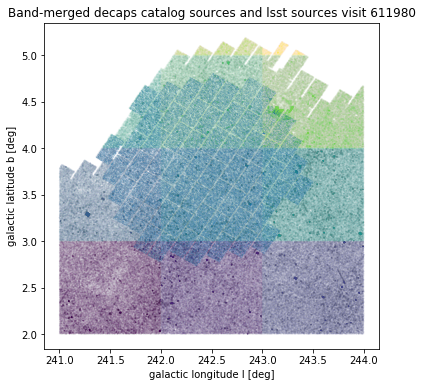

In [548]:
# plot the ra,dec of all lsst sources and all decaps tiles
# to ensure that we are covering the entire desired region .. 

lsst_coord = SkyCoord(ra = ccd_lsst_stack['coord_ra']*u.radian, 
                      dec= ccd_lsst_stack['coord_dec']*u.radian) 

decaps_coord = SkyCoord(ra = decaps_stack['ra'].data.data * u.degree, 
                       dec = decaps_stack['dec'].data.data*u.degree )
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(decaps_coord.galactic.l.degree, decaps_coord.galactic.b.degree, s=0.0001,
           c = decaps_stack['flag_tile'])
ax.scatter(lsst_coord.galactic.l.degree, lsst_coord.galactic.b.degree, s = 0.0001)
ax.set_xlabel('galactic longitude l [deg]')
ax.set_ylabel('galactic latitude b [deg]')
ax.set_title('Band-merged decaps catalog sources and lsst sources visit '+visit)
plt.savefig('../data_products/decaps_lsst_compare/611980/'+\
            'band_merged_and_lsst_sources.png')

In [502]:
decaps_stack['ra'].data.data

array([ 119.09662545,  119.09535915,  119.09545635, ...,  119.09095109,
        118.90230485,  119.19808208])

In [593]:
# Ok, now we can use this data to compare the lsst g magnitudes
# to the band-merged magnitudes... 

# match the lsst source catalog  onto decam band-merged catalog: 
#  ccd_lsst_stack  vs decaps_stack  


# indices are into decaps stacked catalog 
# match lsst into decaps ... 
idx, d2d, d3d = lsst_coord.match_to_catalog_sky(decaps_coord)  

# stack the two catalogs 
lsst_decaps= hstack([ccd_lsst_stack ,decaps_stack[idx]],
               table_names=['lsst','decaps']  )
lsst_decaps.rename_column('g','decaps_mag')

print('There are %d decaps sources  and %d lsst sources.'%(len(decaps_coord),
                                                      len(lsst_coord))
     )

# matches within two arcsec...
cut_arcsec = 2 
mask_arcsec = d2d.arcsec < cut_arcsec



There are 1199825 decaps sources  and 275098 lsst sources.


In [558]:
#lsst_decaps

In [594]:
# matches within 0.5 mag from one another ... 
lsst_decaps['dmag'] = lsst_decaps['lsst_mag'] - lsst_decaps['decaps_mag']
cut_mag = 0.5


In [595]:
#np.median(lsst_decaps['dmag'])

In [596]:
lsst_decaps['lsst_corr'] = lsst_decaps['lsst_mag'] - np.median(lsst_decaps['dmag'])

lsst_decaps['dmag_corr'] = lsst_decaps['lsst_corr'] - lsst_decaps['decaps_mag']
mask_mag = abs(lsst_decaps['dmag_corr'].data) < cut_mag
mask_comb  = mask_arcsec * mask_mag


print(' %d lsst srcs have a decaps match within %d arcsec'%(
    np.sum(mask_arcsec), cut_arcsec)
     )
print(' %d lsst srcs have a decaps match within %.2f mag'%(
    np.sum(mask_mag), cut_mag)
     )
print(' %d lsst srcs have a decaps match fulfilling both criteria'%np.sum(mask_comb)
     )


 251281 lsst srcs have a decaps match within 2 arcsec
 251335 lsst srcs have a decaps match within 0.50 mag
 246284 lsst srcs have a decaps match fulfilling both criteria


(14, 23)

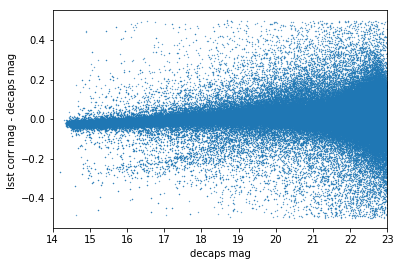

In [597]:
# plot lsst mag corrected by the median magnitude difference : 

plt.scatter(lsst_decaps[mask_comb]['decaps_mag'],lsst_decaps[mask_comb]['dmag_corr'],
           s=0.1)
plt.xlabel('decaps mag')
plt.ylabel('lsst corr mag - decaps mag ')
plt.xlim(14,23)



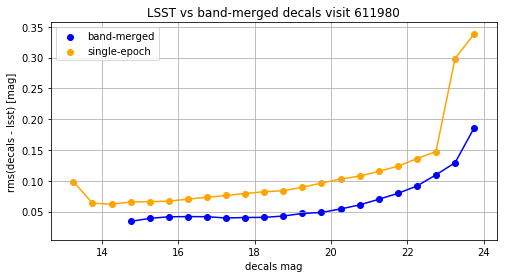

In [601]:
# plot the photometric error vs magnitude ....
# calculate the rms only on sources that were matched... 
rms = lambda x : np.sqrt(np.mean(np.square(x)))
stat_rms = bs(lsst_decaps[mask_comb]['decaps_mag'],
              lsst_decaps[mask_comb]['dmag_corr'], 
              bins=bins,statistic=rms)
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(stat_rms.bin_edges[2:]+0.25, stat_rms.statistic[1:], c='blue', 
           label='band-merged')
ax.plot(stat_rms.bin_edges[2:]+0.25, stat_rms.statistic[1:],c='blue')

ax.scatter(stat_rms_single.bin_edges[2:]+0.25, stat_rms_single.statistic[1:], c='orange',
          label='single-epoch')
ax.plot(stat_rms_single.bin_edges[2:]+0.25, stat_rms_single.statistic[1:], c='orange')

plt.legend()
ax.set_ylabel('rms(decals - lsst) [mag]')
ax.set_xlabel('decals mag')
ax.grid()
ax.set_title('LSST vs band-merged decals visit '+visit)
fname = '../data_products/decaps_lsst_compare/'+'band_merged_visit_'+visit+'_rms.png'
plt.savefig(fname)

In [590]:
stat_rms_single

BinnedStatisticResult(statistic=array([ 0.31650671,  0.09866615,  0.06362205,  0.06205165,  0.06555258,
        0.06619199,  0.06686498,  0.07021822,  0.07326077,  0.0761168 ,
        0.07933727,  0.08223143,  0.08381979,  0.08959369,  0.09624048,
        0.10271649,  0.10761773,  0.11524334,  0.12360347,  0.13584641,
        0.14743901,  0.29838169,  0.3382826 ]), bin_edges=array([ 12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,  15.5,  16. ,
        16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,  20.5,
        21. ,  21.5,  22. ,  22.5,  23. ,  23.5]), binnumber=array([14, 17, 12, ..., 21, 21, 21]))

In [591]:
stat_rms

BinnedStatisticResult(statistic=array([        nan,         nan,         nan,         nan,  0.03406597,
        0.03900614,  0.04156458,  0.0418721 ,  0.04174246,  0.03961142,
        0.04040375,  0.04064434,  0.04280828,  0.0469478 ,  0.04864856,
        0.05429506,  0.0608675 ,  0.06993336,  0.07958722,  0.09147819,
        0.10964748,  0.12928923,  0.18580277]), bin_edges=array([ 12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,  15.5,  16. ,
        16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,  20.5,
        21. ,  21.5,  22. ,  22.5,  23. ,  23.5]), binnumber=array([15, 19, 17, ..., 15, 16, 17]))